In [462]:
import pickle, os, glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from matplotlib.patches import Rectangle
from scipy.special import erf
from scipy.special import gamma

In [463]:
#path = "D:/data/SiPM/waveforms/20240515/pb212"
path = "D:/data/SiPM/waveforms/20240516/pb212_cleaned" ## cleaned folder is after sonicating everything
                                                       ## should be same as version given to Jiaxiang for install
filename_list = ["Pb212_28V_x0.0_y0.0_*.pkl",] 
save_str = ["Pb212",]
ov_list = [28,]
data_time = [10, ] ## acquisition time in seconds

In [464]:
ovs_dict = {}

fsample = 62.5e6 ## sampling rate in Hz
record_length = 129 ## not clear why this differs from the 128 set above
time_vec = np.arange(0, record_length/fsample, 1/fsample)

for j,filename in enumerate(filename_list):
    
    curr_files = glob.glob(os.path.join(path, filename))
    
    data_dict = {}

    wfidx = 0
    for cidx, cf in enumerate(curr_files):
        
        with open(cf, 'rb') as fin:
            curr_dict = pickle.load(fin)

            for wf in curr_dict:

                sum_waveform = np.zeros_like(time_vec)	
                
                ## subtract baseline
                baseline = 2048 

                channel_dict = {}
                for k, ch in enumerate(range(16,-1,-2)):
                    channel_dict[k] = wf[ch] - baseline
                    sum_waveform += (wf[ch] - baseline)

                channel_dict[9] = sum_waveform

                data_dict[wfidx] = channel_dict
                wfidx += 1

    nwaveforms = wfidx
    print("Got %d waveforms"%nwaveforms + " for %d files: "%len(curr_files) + filename)
    data_dict['time'] = time_vec*1e9

    ovs_dict[ov_list[j]] = {'nwaveforms': nwaveforms, 'data_dict': data_dict}

Got 113553 waveforms for 111 files: Pb212_28V_x0.0_y0.0_*.pkl


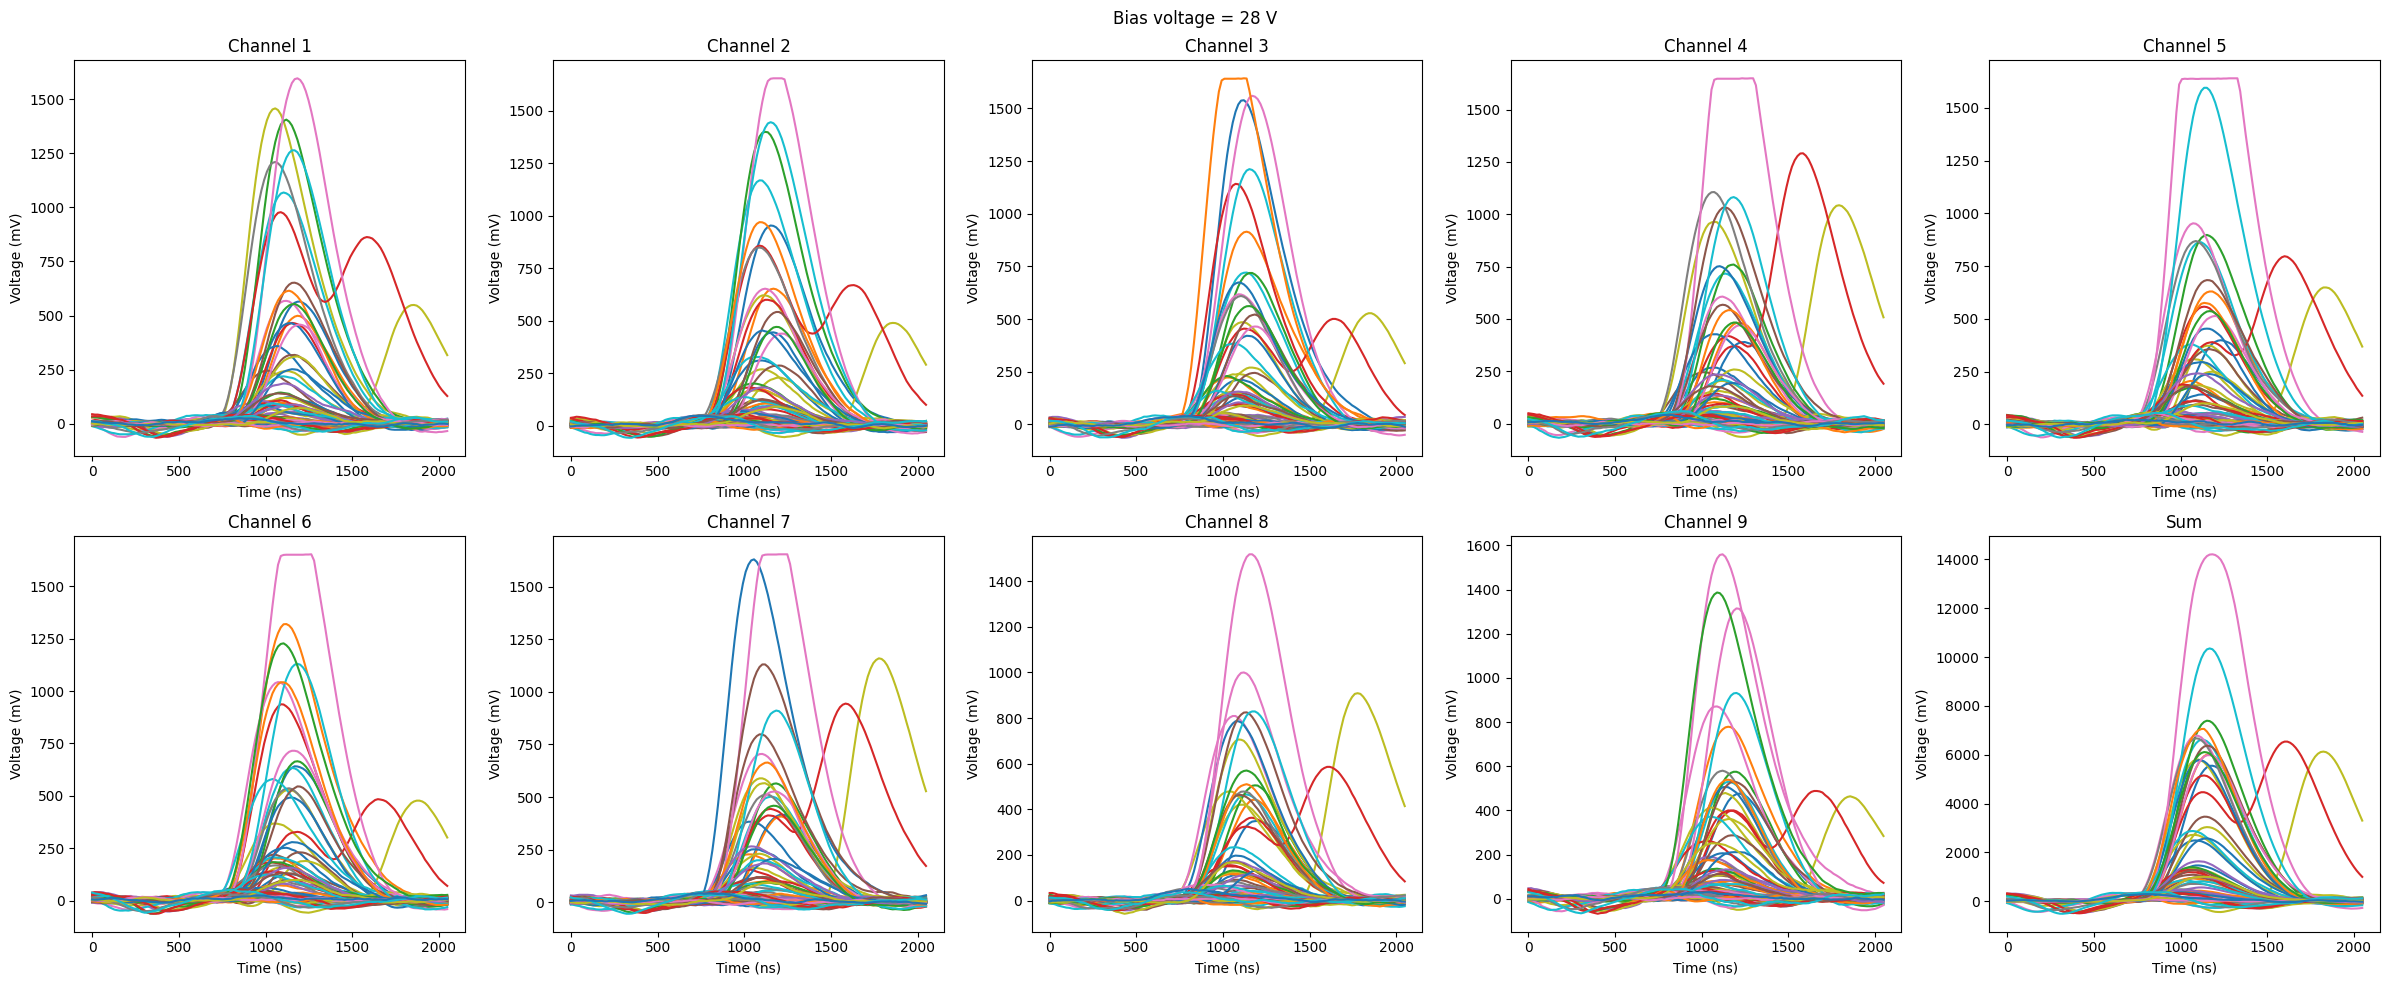

In [465]:
make_plot = True
max_figs = 100

for ov in ov_list:

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    if(nwaveforms > max_figs):
        downsamp = int(nwaveforms/max_figs)
    else:
        downsamp = 1

    if(make_plot):

        plt.figure(figsize=(24,10))

        for j in range(nwaveforms):
            if(j%downsamp != 0): continue

            for ch in range(10):
                plt.subplot(2,5,ch+1)
                plt.plot(data_dict['time'], data_dict[j][ch])
                plt.xlabel('Time (ns)')
                plt.ylabel('Voltage (mV)')
                if(ch < 9):
                    plt.title("Channel %d"%(ch+1))
                else:
                    plt.title("Sum")

        plt.suptitle("Bias voltage = %s V"%str(ov))
    plt.tight_layout()


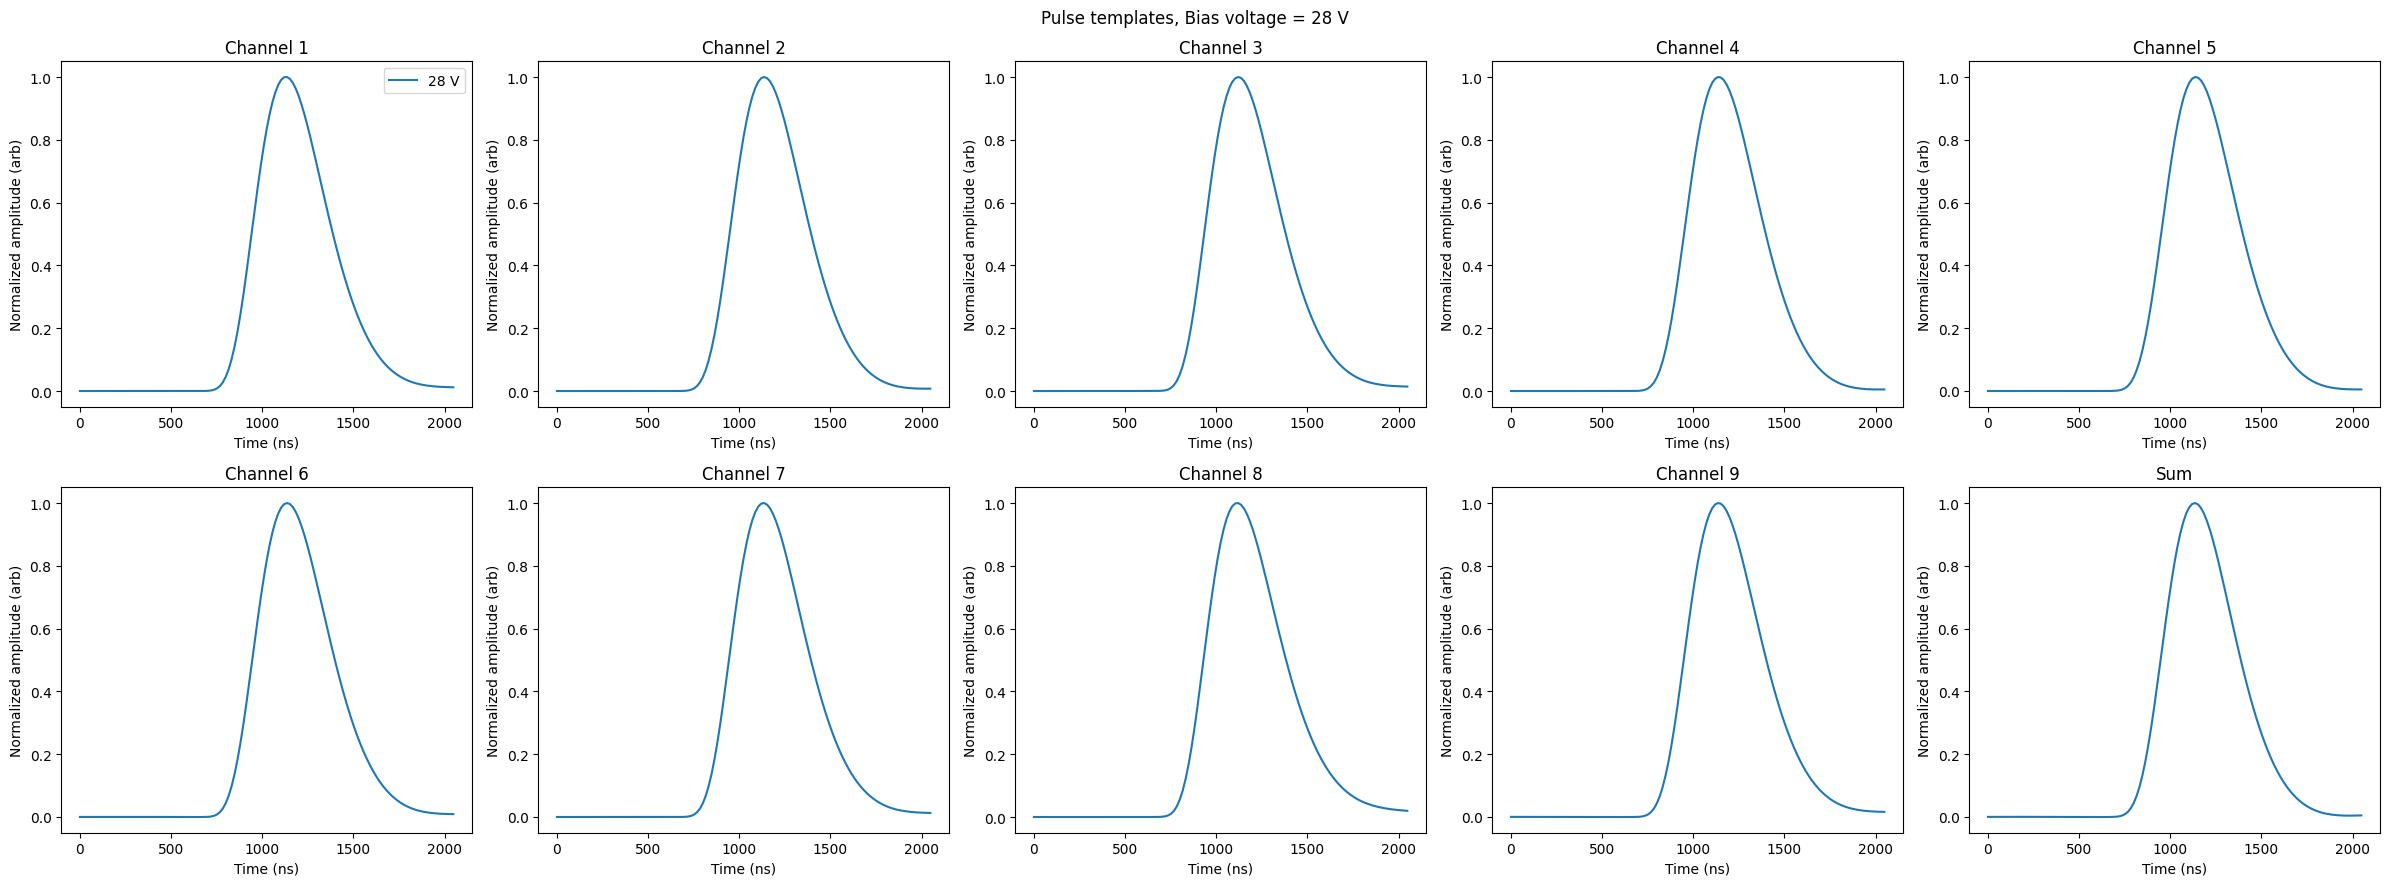

In [466]:
template_ch_dict = {}

min_vals = [500, 2000]

for ov in ov_list:

    plt.figure(figsize=(24,9))

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    ## make average template
    template_dict = {}
    nwfm = np.zeros(10)
    for ch in range(10):
        template_dict[ch] = np.zeros(len(data_dict['time']))

    for j in range(nwaveforms):

        cdat = data_dict[j]

        for ch in range(10):

            ## throw out bad traces
            min_val = min_vals[0] if ch < 9 else min_vals[1]
            if np.max(cdat[ch]) < min_val:
                continue

            template_dict[ch] += cdat[ch]
            nwfm[ch] += 1

    for ch in range(10):
        plt.subplot(2,5,ch+1)
        template_dict[ch] /= nwfm[ch]
        template_dict[ch] -= np.median(template_dict[ch][:20])
        template_dict[ch] /= np.max(template_dict[ch])

        plt.plot(data_dict['time'], template_dict[ch], label="%s V"%str(ov))
        plt.xlabel('Time (ns)')
        plt.ylabel('Normalized amplitude (arb)')

        if(ch < 9):
            plt.title("Channel %d"%(ch+1))
        else:
            plt.title("Sum")

    template_ch_dict[ov] = template_dict

    plt.suptitle("Pulse templates, Bias voltage = %s V"%str(ov))
    plt.subplot(2,5,1)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [467]:
def gauss(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [468]:
remake_files = True

tscan = 500 ## time to scan around the template in ns
pts_to_scan = int(tscan*1e-9 * fsample * 0.5)
print("scanning +/-%d points"%pts_to_scan)

for oidx, ov in enumerate(ov_list):

    if(remake_files):

        window  = [800, 1300]

        data_dict = ovs_dict[ov]['data_dict']

        mpts = (data_dict['time'] > window[0]) & (data_dict['time'] < window[1])

        recon_amps_max = []   
        recon_amps_fit = []   
          
        for k in data_dict.keys():
            if k == 'time': continue

            cdat_dict = data_dict[k]
            
            channel_max = np.zeros(10)
            channel_fit = np.zeros(10)
            for ch in range(10):

                cdat = cdat_dict[ch]

                shortened_temp = template_ch_dict[ov][ch][pts_to_scan:-pts_to_scan]

                #fit = np.sum( cdat*template_ch_dict[ov][ch] ) / np.sum(template_ch_dict[ov][ch]**2)
                fit_all = np.correlate(cdat, shortened_temp) / np.sum(shortened_temp**2)
                fit = np.max(np.abs(fit_all))

                midx = np.argmax(np.abs(cdat[mpts]))
                max_val = cdat[mpts][midx]
                
                channel_max[ch] = max_val
                channel_fit[ch] = fit
            
            recon_amps_max.append(channel_max)
            recon_amps_fit.append(channel_fit)

        recon_amps_max = np.array(recon_amps_max)
        recon_amps_fit = np.array(recon_amps_fit)

        np.savez( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)), recon_amps_max=recon_amps_max, 
                                                                                  recon_amps_fit=recon_amps_fit,
                                                                                  nwaveforms=nwaveforms)

    

scanning +/-15 points


In [469]:
### isotope data

se = 1.8 # fudge factor for secular inequilibrium  

## energy [keV]    Intensity    Compton [cm^2/g]     PE [cm^2/g]    type
pb_212_data = [[154, 0.05, -1, -1, 1, 'beta'],  ##pb 212
               [331, 0.815, -1, -1, 2, 'beta'],
               [569, 0.137, -1, -1, 3, 'beta'],
               [148, 0.31, -1, -1, 4, 'electron'],
               [210, 0.0125, -1, -1, 5, 'electron'],
               [222, 0.0537, -1, -1, 6, 'electron'],
               [235, 0.0126, -1, -1, 7, 'electron'],
               [239, 0.436, 0.1247, 5.52e-5, 8, 'gamma'],
               [300, 0.033, 0.1151, 2.76e-5, 9, 'gamma'],
               [6051, 0.251, -1, -1, 10, 'alpha'], ##bi 212
               [6090, 0.0975, -1, -1, 11, 'alpha'],
               [631, 0.0186, -1, -1, 12, 'beta'],
               [739, 0.0144, -1, -1, 13, 'beta'],
               [1524, 0.0447, -1, -1, 14, 'beta'],
               [2251.5, 0.5537, -1, -1, 15, 'beta'],
               [8785, 0.64*0.8, -1, -1, 16, 'alpha'], ##po 212   
               [1038, 0.36*0.0318*se, -1, -1, 17, 'beta'], ## tl 208     
               [1291, 0.36*0.242*se, -1, -1, 18, 'beta'], 
               [1524, 0.36*0.222*se, -1, -1, 19, 'beta'],      
               [1801, 0.36*0.491*se, -1, -1, 20, 'beta'],    
               [277, 0.36*0.066*se, 0.1185, 0, 21, 'gamma'],   
               [510, 0.36*0.226*se, 0.0935, 0, 22, 'gamma'],          
               [583, 0.36*0.85*se, 0.0883, 0, 23, 'gamma'],     
               [861, 0.36*0.125*se, 0.074, 0, 24, 'gamma'],      
               [2615, 0.36*0.9975*se, 0.0406, 0, 25, 'gamma'],     
               ]
pb212_list = [1,2,3,4,5,6,7,8,9]
bi212_list = [10,11,12,13,14,15]
po212_list = [16]
tl208_list = [17,18,19,20,21,22,23,24,25]


In [470]:
# constants needed
m_e = 511 ## electron mass in keV
thickness = 1 ## cm
density = 1 ## g/cm^3
alpha = 1/137.036 ## fine structure constant
R0 = 1.03e6 ## nuclear radius [keV]

In [471]:
def fermi_func(A, Z, E):
  ## Z should be positive for beta minus decay
  gpts = E > 0
  f = np.zeros_like(E)
  R = R0 * A**(1/3)
  Et = E[gpts] + m_e
  p = np.sqrt( (Et)**2 - m_e**2 )
  eval = 2*(np.sqrt(1 - alpha**2 * Z**2)-1)
  gam = np.abs( gamma(np.sqrt(1 - alpha**2 * Z**2) + 1j* alpha * Z * Et/p ) )**2 / gamma(2*np.sqrt(1-alpha**2 * Z**2) + 1)**2
  f[gpts] = 2*(1 + np.sqrt(1-alpha**2 * Z**2) ) * (2*p*R)**eval * np.exp(np.pi*alpha*Z*Et/p) * gam
  return f

def simple_beta(E, Q, ms=0, A=212, Z=82):
  #return a simple spectrum of counts vs electron KE
  ## assumes E in keV
  ## Q is Q value in keV
  ## ms is nu mass in keV
  N = np.zeros_like(E)
  gpts = E < Q-ms
  N[gpts] = np.sqrt(E[gpts]**2 + 2*E[gpts]*m_e)*(E[gpts] + m_e)*np.sqrt((Q-E[gpts])**2 - ms**2)*(Q-E[gpts])
  ff = fermi_func(A, Z+1, E) ## Z+1 for the daughter 
  out = N*ff
  out[np.isnan(out)] = 0
  out[np.isinf(out)] = 0
  return out

In [472]:
def expected_spectrum(E, A, sigma, cal, iso_data=pb_212_data, lines=None):

    spectrum_out = np.zeros_like(E)
    cal_E = cal*E
    for rad in iso_data:

        if(lines):
            if rad[4] not in lines: 
                continue

        if(rad[-1] == 'gamma'):
            ## first add the compton
            compton_edge = rad[0] * (1 - 1/(1 + 2*rad[0]/m_e))
            spectrum_out += A*rad[1]/compton_edge * (1 - np.exp(-thickness * (rad[2] * density))) * (1-erf((cal_E-compton_edge)/(np.sqrt(2)*sigma)))

            ## now the photoelectric
            spectrum_out += 2*np.pi*A*rad[1]*(1 - np.exp(-thickness * (rad[3] * density)))/(np.sqrt(2*np.pi)*sigma) * np.exp(-(cal_E-rad[0])**2/(2*sigma**2))
        elif(rad[-1] == 'electron'):
            electron_e_fudge = 1
            electron_sig_fudge = np.sqrt(rad[0]*electron_e_fudge/148)
            spectrum_out += A*rad[1]/(np.sqrt(2*np.pi)*sigma*electron_sig_fudge) * np.exp(-(cal_E-rad[0]*electron_e_fudge)**2/(2*(sigma*electron_sig_fudge)**2))
        elif(rad[-1] == 'beta'):
            beta_spec = simple_beta(E, rad[0])
            norm = np.trapz(beta_spec, E)
            spectrum_out += A*rad[1]*beta_spec/norm
        elif(rad[-1] == 'alpha'):
            alpha_e_fudge = 0.078 * (1 + 0.00021*(rad[0]-6051)) ## alpha quenching
            alpha_sig_fudge = np.sqrt(rad[0]*alpha_e_fudge/148) ## sqrt dependence for e res 
            spectrum_out += A*rad[1]/(np.sqrt(2*np.pi)*(sigma*alpha_sig_fudge)) * np.exp(-(cal_E-rad[0]*alpha_e_fudge)**2/(2*(sigma*alpha_sig_fudge)**2))

    return spectrum_out

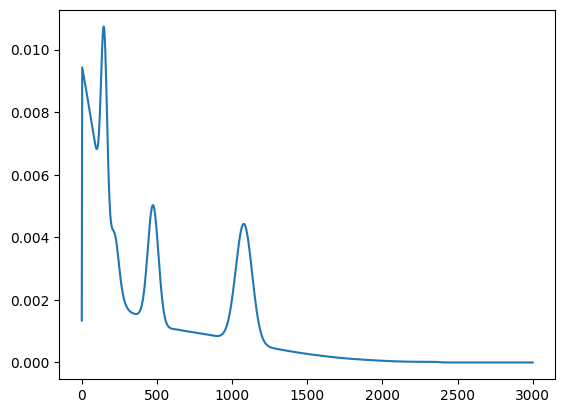

In [473]:
ee = np.linspace(0,3000, 1000)
plt.plot(ee, expected_spectrum(ee, 1, 20, 1))

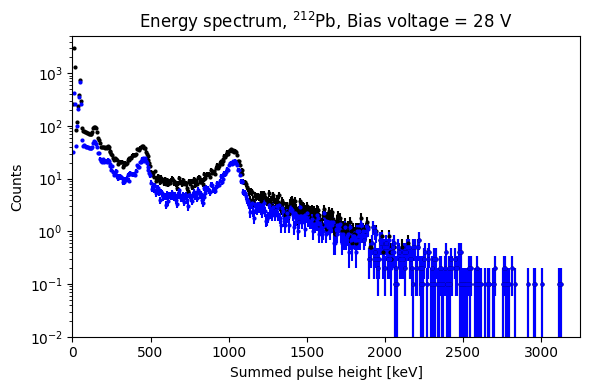

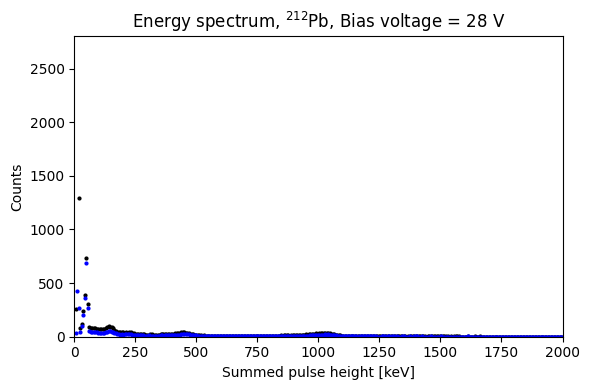

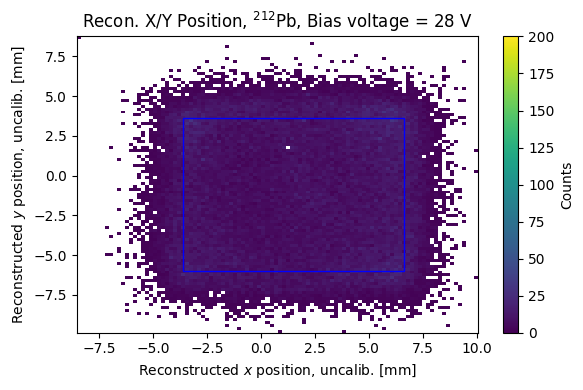

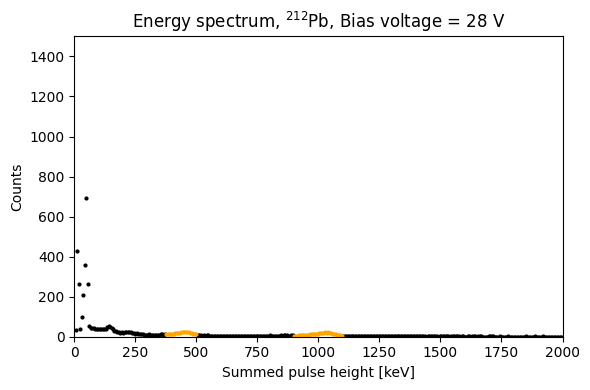

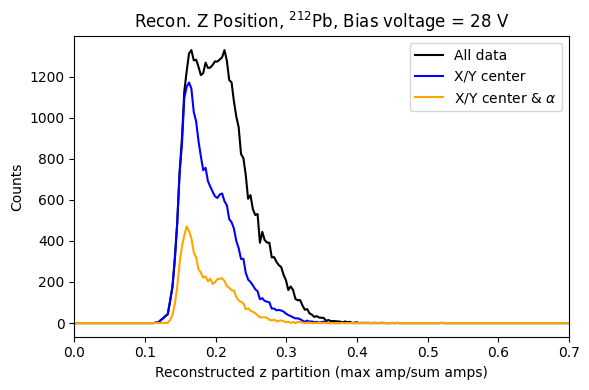

In [484]:
## plot and fit
save_figs = True

sipm_coords_x = np.array([-6.5, 0, 6.5, -6.5, 0, 6.5, -6.5, 0, 6.5])
sipm_coords_y = np.array([6.5, 6.5, 6.5, 0, 0, 0, -6.5, -6.5, -6.5])

cal_type_list = ['channel cal']

eng_fig = plt.figure(figsize=(6, 4))
lin_eng_fig = plt.figure(figsize=(6, 4))
alpha_cut_fig = plt.figure(figsize=(6, 4))
pos_fig = plt.figure(figsize=(6, 4))
z_fig = plt.figure(figsize=(6, 4))


xy_cal_fac = 3

for oidx, ov in enumerate(ov_list):

    data = np.load( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)) )
    recon_amps_max = data['recon_amps_max']
    recon_amps_fit = data['recon_amps_fit']
    nwaveforms = data['nwaveforms']

    bins = np.linspace(0, 30000, 800)
    bc = bins[:-1] + np.diff(bins)

    norm = data_time[oidx]

    fit_amps = recon_amps_fit[:,9]
    h_fit, be = np.histogram( fit_amps, bins=bins )

    fpts = bc > 2000

    errs = np.sqrt(h_fit[fpts])
    errs[errs==0] = 1
    spars = [np.max(h_fit), np.median(fit_amps), np.std(fit_amps)]
    gc_fit = spars

    eng_cal_fac_fit = 0.162 #am241_alpha_eng/np.abs(gc_fit[1])

    amps = recon_amps_fit
    recon_x = (amps[:,:9] @ sipm_coords_x.T)/np.sum(amps[:,:9], axis = 1)
    recon_y = (amps[:,:9] @ sipm_coords_y.T)/np.sum(amps[:,:9], axis = 1)
    recon_z = np.max(np.abs(amps[:,:9]), axis = 1)/np.sum(amps[:,:9], axis = 1)

    recon_r = np.sqrt(recon_x**2 + recon_y**2)
    xcut = np.array([-1.2, 2.2])
    ycut = np.array([-2, 1.2])
    zcut = [0,1]
    cpts = ((recon_x > xcut[0]) & (recon_x < xcut[1])) & ((recon_y > ycut[0]) & (recon_y < ycut[1])) & ((recon_z > zcut[0]) & (recon_z < zcut[1]))

    h_fit_cent, be = np.histogram( fit_amps[cpts], bins=bins )

    bi212_cut = [375, 500]
    po212_cut = [900, 1100]

    cal_eng = bc*eng_cal_fac_fit
    cal_eng_pts = fit_amps*eng_cal_fac_fit

    bi212_bpts = (cal_eng>bi212_cut[0]) & (cal_eng<bi212_cut[1])
    po212_bpts = (cal_eng>po212_cut[0]) & (cal_eng<po212_cut[1])
    alpha_bpts = bi212_bpts | po212_bpts

    bi212_cpts = (cal_eng_pts>bi212_cut[0]) & (cal_eng_pts<bi212_cut[1])
    po212_cpts = (cal_eng_pts>po212_cut[0]) & (cal_eng_pts<po212_cut[1])
    alpha_cpts = bi212_cpts | po212_cpts

    if('bkg' in str(ov)): 
        continue

    xx = np.linspace(0, bc[-1], 1000)

    plt.figure(eng_fig.number)
    plt.errorbar(bc*eng_cal_fac_fit, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='ko', markersize=2)    
    plt.errorbar(bc*eng_cal_fac_fit, h_fit_cent/norm, yerr=np.sqrt(h_fit_cent)/norm, fmt='bo', markersize=2)
    #plt.plot(bc*eng_cal_fac_fit, h_fit/norm, 'k')
    plt.gca().set_yscale('log')
    #plt.plot(xx*eng_cal_fac_fit, gauss(xx, *gc_fit)/norm, 'orange')
    plt.xlabel("Summed pulse height [keV]")
    plt.ylabel("Counts")
    plt.xlim(0,3250)
    plt.title("Time fit to template")
    plt.ylim(0.01,5e3)
    #plt.legend()
    plt.title("Energy spectrum, $^{212}$Pb, Bias voltage = %s V"%str(ov))
    if(save_figs):
        plt.tight_layout()
        plt.savefig(os.path.join(path, 'plots', 'eng_spec_pb212.png') )    

    plt.figure(lin_eng_fig.number)
    plt.errorbar(bc*eng_cal_fac_fit, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='ko', markersize=2)    
    plt.errorbar(bc*eng_cal_fac_fit, h_fit_cent/norm, yerr=np.sqrt(h_fit_cent)/norm, fmt='bo', markersize=2)
    #plt.plot(bc*eng_cal_fac_fit, h_fit/norm, 'k')
    #plt.gca().set_yscale('log')
    #plt.plot(xx*eng_cal_fac_fit, gauss(xx, *gc_fit)/norm, 'orange')
    plt.xlabel("Summed pulse height [keV]")
    plt.ylabel("Counts")
    plt.xlim(0,2000)
    plt.title("Time fit to template")
    plt.ylim(0,2800)
    #plt.legend()
    plt.title("Energy spectrum, $^{212}$Pb, Bias voltage = %s V"%str(ov))
    if(save_figs):
        plt.tight_layout()
        plt.savefig(os.path.join(path, 'plots', 'lin_eng_spec_pb212.png') )    

    plt.figure(pos_fig.number)
    #plt.plot(recon_x[::20], recon_y[::20], 'ko', ms=0.5)
    #plt.plot(recon_x[cpts][::20], recon_y[cpts][::20], 'bo', ms=0.5)
    e_cut = cal_eng_pts > 100
    hpos, xedge, yedge = np.histogram2d(recon_x[e_cut]*xy_cal_fac, recon_y[e_cut]*xy_cal_fac, bins=100)
    hpos[hpos == 0] = np.nan
    plt.pcolormesh(xedge, yedge, hpos, vmin=0, vmax=200)
    plt.colorbar(label="Counts")
    rect = Rectangle((xcut[0]*xy_cal_fac, ycut[0]*xy_cal_fac), np.diff(xcut)[0]*xy_cal_fac, np.diff(ycut)[0]*xy_cal_fac, edgecolor='blue', facecolor="none")
    ax = plt.gca()
    ax.add_patch(rect)
    plt.title("Recon. X/Y Position, $^{212}$Pb, Bias voltage = %s V"%str(ov))
    plt.xlabel("Reconstructed $x$ position, uncalib. [mm]")
    plt.ylabel("Reconstructed $y$ position, uncalib. [mm]")
    if(save_figs):
        plt.tight_layout()
        plt.savefig(os.path.join(path, 'plots', 'xy_pos_pb212.png') )   

    plt.figure(alpha_cut_fig.number)
    #plt.errorbar(bc*eng_cal_fac_fit, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='ko', markersize=2)    
    plt.errorbar(cal_eng[~alpha_bpts], h_fit_cent[~alpha_bpts]/norm, yerr=np.sqrt(h_fit_cent[~alpha_bpts])/norm, fmt='ko', markersize=2)
    plt.errorbar(cal_eng[alpha_bpts], h_fit_cent[alpha_bpts]/norm, yerr=np.sqrt(h_fit_cent[alpha_bpts])/norm, fmt='o', color='orange', markersize=2)
    #plt.plot(bc*eng_cal_fac_fit, h_fit/norm, 'k')
    #plt.gca().set_yscale('log')
    #plt.plot(xx*eng_cal_fac_fit, gauss(xx, *gc_fit)/norm, 'orange')
    plt.xlabel("Summed pulse height [keV]")
    plt.ylabel("Counts")
    plt.xlim(0,2000)
    plt.title("Time fit to template")
    plt.ylim(0,1500)
    #plt.legend()
    plt.title("Energy spectrum, $^{212}$Pb, Bias voltage = %s V"%str(ov))
    if(save_figs):
        plt.tight_layout()
        plt.savefig(os.path.join(path, 'plots', 'alpha_cut_pb212.png') )    

    plt.figure(z_fig.number)
    zbins = np.linspace(0,1,300)
    h_z, bez = np.histogram( recon_z[e_cut], bins=zbins )
    bcz = bez[:-1] + np.diff(bez)/2
    plt.plot(bcz, h_z, 'k', label='All data')

    h_z_cut, bez = np.histogram( recon_z[e_cut & cpts], bins=zbins )
    plt.plot(bcz, h_z_cut, 'b', label='X/Y center')

    h_z_alphacut, bez = np.histogram( recon_z[e_cut & cpts & alpha_cpts], bins=zbins )
    plt.plot(bcz, h_z_alphacut, 'orange', label=r'X/Y center & $\alpha$')

    plt.xlim(0,0.7)
    plt.xlabel("Reconstructed z partition (max amp/sum amps)")
    plt.ylabel('Counts')
    plt.title("Recon. Z Position, $^{212}$Pb, Bias voltage = %s V"%str(ov))
    plt.legend()
    if(save_figs):
        plt.tight_layout()
        plt.savefig(os.path.join(path, 'plots', 'z_pos_pb212.png') )   

plt.show()

[3.94565926e+03 1.70000000e+01 1.05794964e+00]


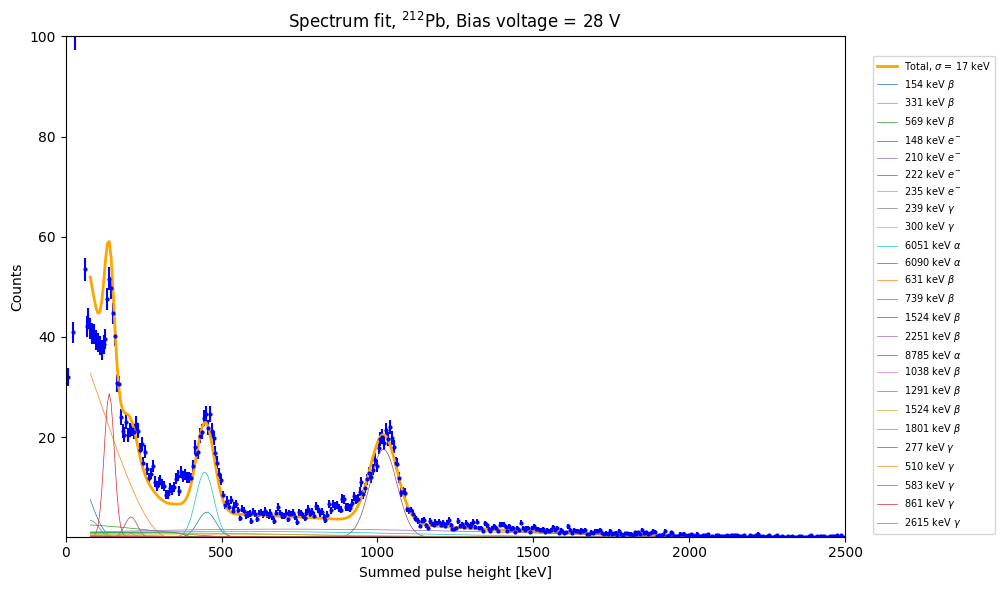

In [475]:
fit_fig = plt.figure(figsize=(10, 6))
fig=plt.figure(fit_fig.number)
evals = bc*eng_cal_fac_fit
plt.errorbar(evals, h_fit_cent/norm, yerr=np.sqrt(h_fit_cent)/norm, fmt='bo', markersize=2)
#plt.gca().set_yscale('log')
fpts = (evals > 75) & (evals < 2000)
spars = [2.5e3, 14, 1]
err=np.sqrt(h_fit_cent[fpts])
err[err==0] = 1
err /= norm
spec_bp, _ = curve_fit(expected_spectrum, evals[fpts], h_fit_cent[fpts]/norm, sigma=err, p0=spars)
spec_bp[1] = 17
#spec_bp = spars
print(spec_bp)
plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp), 'orange', lw=2, label=r"Total, $\sigma$ = %d keV"%spec_bp[1])
for i in range(1,26):
        curr_dat = pb_212_data[i-1]
        if(curr_dat[-1] == 'gamma'):
            plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp, lines=[i]) , lw=0.5, label=r"%d keV $\gamma$"%curr_dat[0])
        elif(curr_dat[-1] == 'alpha'):
            plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp, lines=[i]) , lw=0.5, label=r"%d keV $\alpha$"%curr_dat[0])    
        elif(curr_dat[-1] == 'beta'):
            plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp, lines=[i]) , lw=0.5, label=r"%d keV $\beta$"%curr_dat[0])     
        elif(curr_dat[-1] == 'electron'):
            plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp, lines=[i]) , lw=0.5, label=r"%d keV $e^-$"%curr_dat[0])      

plt.xlim(0,2500)
plt.ylim(0.1, 100)
fig.legend(loc = 'outside right', fontsize=7)
plt.xlabel("Summed pulse height [keV]")
plt.ylabel("Counts")
plt.title("Spectrum fit, $^{212}$Pb, Bias voltage = %s V"%str(ov))
if(save_figs):
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.savefig(os.path.join(path, 'plots', 'spec_fit_pb212.png') )   

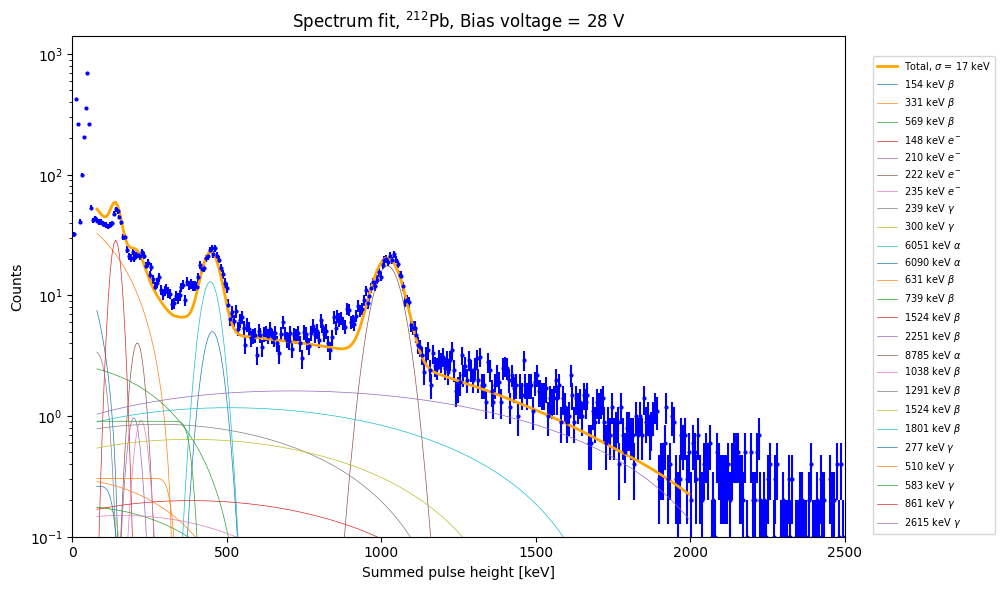

In [476]:
fit_fig = plt.figure(figsize=(10, 6))
fig=plt.figure(fit_fig.number)
evals = bc*eng_cal_fac_fit
plt.errorbar(evals, h_fit_cent/norm, yerr=np.sqrt(h_fit_cent)/norm, fmt='bo', markersize=2)
plt.gca().set_yscale('log')

plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp), 'orange', lw=2, label=r"Total, $\sigma$ = %d keV"%spec_bp[1])
for i in range(1,26):
        curr_dat = pb_212_data[i-1]
        if(curr_dat[-1] == 'gamma'):
            plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp, lines=[i]) , lw=0.5, label=r"%d keV $\gamma$"%curr_dat[0])
        elif(curr_dat[-1] == 'alpha'):
            plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp, lines=[i]) , lw=0.5, label=r"%d keV $\alpha$"%curr_dat[0])    
        elif(curr_dat[-1] == 'beta'):
            plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp, lines=[i]) , lw=0.5, label=r"%d keV $\beta$"%curr_dat[0])     
        elif(curr_dat[-1] == 'electron'):
            plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp, lines=[i]) , lw=0.5, label=r"%d keV $e^-$"%curr_dat[0])      

plt.xlim(0,2500)
plt.ylim(0.1, 1400)
fig.legend(loc = 'outside right', fontsize=7)
plt.xlabel("Summed pulse height [keV]")
plt.ylabel("Counts")
plt.title("Spectrum fit, $^{212}$Pb, Bias voltage = %s V"%str(ov))
if(save_figs):
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.savefig(os.path.join(path, 'plots', 'spec_fit_log_pb212.png') )   

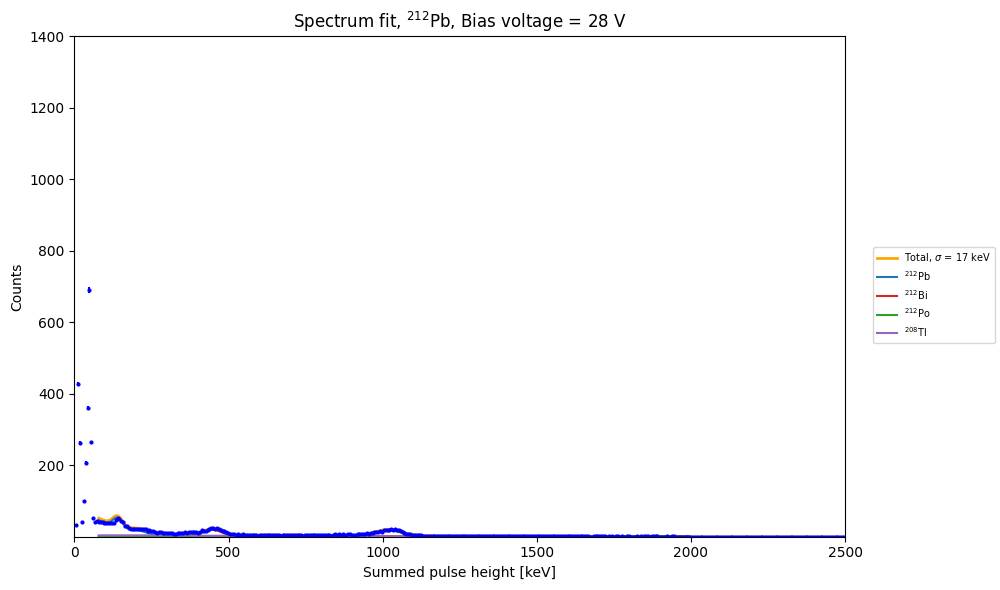

In [477]:
## simpler fit by isotope

fit_fig = plt.figure(figsize=(10, 6))
fig=plt.figure(fit_fig.number)
evals = bc*eng_cal_fac_fit
plt.errorbar(evals, h_fit_cent/norm, yerr=np.sqrt(h_fit_cent)/norm, fmt='bo', markersize=2)
#plt.gca().set_yscale('log')
plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp), 'orange', lw=2, label=r"Total, $\sigma$ = %d keV"%spec_bp[1])
lab_list = ["$^{212}$Pb","$^{212}$Bi","$^{212}$Po","$^{208}$Tl"]
col_list = ["tab:blue", "tab:red", "tab:green", "tab:purple"]
for j,cl in enumerate([pb212_list, bi212_list, po212_list, tl208_list]):

        plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp, lines=cl) , lw=1.5, label=lab_list[j], color=col_list[j])
  

plt.xlim(0,2500)
plt.ylim(0.1, 1400)
fig.legend(loc = 'outside right', fontsize=7)
plt.xlabel("Summed pulse height [keV]")
plt.ylabel("Counts")
plt.title("Spectrum fit, $^{212}$Pb, Bias voltage = %s V"%str(ov))
if(save_figs):
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.savefig(os.path.join(path, 'plots', 'spec_fit_by_iso_pb212.png') )   

In [478]:
## now with/without foil
if(False):
    path_list = ["D:/data/SiPM/waveforms/20240516/pb212", "D:/data/SiPM/waveforms/20240516/pb212_foil"]
    save_str = ["Pb212",]

    eng_fig = plt.figure(figsize=(6, 4))

    labs = ["No foil", "With foil"]

    for oidx, ov in enumerate(ov_list):

        for j,path in enumerate(path_list):

            data = np.load( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)) )
            recon_amps_max = data['recon_amps_max']
            recon_amps_fit = data['recon_amps_fit']
            nwaveforms = data['nwaveforms']

            bins = np.linspace(0, 30000, 500)
            bc = bins[:-1] + np.diff(bins)

            norm = data_time[oidx]

            fit_amps = recon_amps_fit[:,9]
            h_fit, be = np.histogram( fit_amps, bins=bins )

            fpts = bc > 2000

            errs = np.sqrt(h_fit[fpts])
            errs[errs==0] = 1
            spars = [np.max(h_fit), np.median(fit_amps), np.std(fit_amps)]
            gc_fit = spars

            eng_cal_fac_fit = 0.162 #am241_alpha_eng/np.abs(gc_fit[1])

            amps = recon_amps_fit
            recon_x = (amps[:,:9] @ sipm_coords_x.T)/np.sum(amps[:,:9], axis = 1)
            recon_y = (amps[:,:9] @ sipm_coords_y.T)/np.sum(amps[:,:9], axis = 1)
            recon_z = np.max(np.abs(amps[:,:9]), axis = 1)/np.sum(amps[:,:9], axis = 1)

            recon_r = np.sqrt(recon_x**2 + recon_y**2)
            xcut = np.array([-1.3, 1.8])
            ycut = np.array([-1.6, 1.3])
            zcut = [0,1]
            cpts = ((recon_x > xcut[0]) & (recon_x < xcut[1])) & ((recon_y > ycut[0]) & (recon_y < ycut[1])) & ((recon_z > zcut[0]) & (recon_z < zcut[1]))

            h_fit_cent, be = np.histogram( fit_amps[cpts], bins=bins )

            plt.figure(eng_fig.number)
            plt.errorbar(bc*eng_cal_fac_fit, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='o', markersize=2, label=labs[j])    
            #plt.errorbar(bc*eng_cal_fac_fit, h_fit_cent/norm, yerr=np.sqrt(h_fit_cent)/norm, fmt='bo', markersize=2)


    #plt.gca().set_yscale('log')
    plt.ylim(0,120)
    plt.xlim(0,1500)
    plt.legend()
    plt.xlabel("Summed pulse height [keV]")
    plt.ylabel("Counts")
    if(save_figs):
        plt.tight_layout()
        plt.savefig(os.path.join(path, 'plots', 'spec_with_foil_pb212.png') )   

    plt.gca().set_yscale('log')
    plt.ylim(5e-2,2e2)
    plt.xlim(0,3000)
    plt.legend()
    plt.xlabel("Summed pulse height [keV]")
    plt.ylabel("Counts")
    if(save_figs):
        plt.tight_layout()
        plt.savefig(os.path.join(path, 'plots', 'spec_with_foil_log_pb212.png') )   